# Vehicle Detection Project

### Import Dependencies

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

In [2]:
import keras
from keras.models import Sequential
from keras.layers.convolutional import MaxPooling2D, Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import BatchNormalization, Flatten, Dense, Activation, Reshape

/Users/var/anaconda/envs/carnd-term1/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/var/anaconda/envs/carnd-term1/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


### Constant Values

In [3]:
NORM_H, NORM_W = 416, 416  # normalized image size
GRID_H, GRID_W = 13 , 13  # GRID size for YOLO
BOX = 5  # Box number
CLASS = 20  # Number of classes in VOC dataset
THRESHOLD = 0.3  # threshold for detection of object
ANCHORS = '1.08,1.19,  3.42,4.41,  6.63,11.38,  9.42,5.11,  16.62,10.52'
ANCHORS = [float(ANCHORS.strip()) for ANCHORS in ANCHORS.split(',')]

In [4]:
# code based on 
# https://github.com/joycex99/tiny-yolo-keras
# https://github.com/subodh-malgonde/vehicle-detection

# Bounding box class and drawing code
class BoundBox:
    def __init__(self, class_num):
        self.x, self.y, self.w, self.h, self.c = 0., 0., 0., 0., 0.
        self.probs = np.zeros((class_num,))

    def iou(self, box):
        intersection = self.intersect(box)
        union = self.w*self.h + box.w*box.h - intersection
        return intersection/union

    def intersect(self, box):
        width  = self.__overlap([self.x-self.w/2, self.x+self.w/2], [box.x-box.w/2, box.x+box.w/2])
        height = self.__overlap([self.y-self.h/2, self.y+self.h/2], [box.y-box.h/2, box.y+box.h/2])
        return width * height

    def __overlap(self, interval_a, interval_b):
        x1, x2 = interval_a
        x3, x4 = interval_b
        if x3 < x1:
            if x4 < x1:
                return 0
            else:
                return min(x2,x4) - x1
        else:
            if x2 < x3:
                return 0
            else:
                return min(x2,x4) - x3

def sigmoid(x):
    return 1. / (1.  + np.exp(-x))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def interpret_netout(image, netout):
    boxes = []
    
    # class in VOC dataset which is equal to a car
    car_class_number = 6

    # interpret the output by the network
    for row in range(GRID_H):
        for col in range(GRID_W):
            for b in range(BOX):
                box = BoundBox(CLASS)

                # first 5 weights for x, y, w, h and confidence
                box.x, box.y, box.w, box.h, box.c = netout[row,col,b,:5]

                box.x = (col + sigmoid(box.x)) / GRID_W
                box.y = (row + sigmoid(box.y)) / GRID_H
                box.w = ANCHORS[2 * b + 0] * np.exp(box.w) / GRID_W
                box.h = ANCHORS[2 * b + 1] * np.exp(box.h) / GRID_H
                box.c = sigmoid(box.c)

                # rest of weights for class likelihoods
                classes = netout[row,col,b,5:]
                box.probs = softmax(classes) * box.c
                if box.probs[car_class_number] >= THRESHOLD:
                    boxes.append(box)

    # suppress non-maximal boxes
    # sort according to decreasing order of car prob
    sorted_indices = list(reversed(np.argsort([box.probs[car_class_number] for box in boxes])))

    for i in range(len(sorted_indices)):
        index_i = sorted_indices[i]
    
        if boxes[index_i].probs[car_class_number] == 0:
                continue
        else:
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if boxes[index_i].iou(boxes[index_j]) >= 0.25:
                    boxes[index_j].probs[car_class_number] = 0

    # to handle the cropped images 
    crop_dim = ((500,1280),(350,650))
    [xmin, xmax] = crop_dim[0]
    [ymin, ymax] = crop_dim[1]
    
    # draw the boxes using a threshold
    for box in boxes:
        car_prob = box.probs[car_class_number]
        if car_prob > THRESHOLD:
            w = xmax - xmin
            h = ymax - ymin
            left  = int((box.x - box.w/2) * w)
            right  = int((box.x + box.w/2) * w)
            bot  = int((box.y - box.h/2) * h)
            top  = int((box.y + box.h/2) * h)
            left += xmin
            right += xmin
            bot += ymin
            top += ymin
            cv2.rectangle(image, (left,top), (right, bot), (255,0,0), 5)
            cv2.putText(image, '{0:.2f}'.format(car_prob), (left, top - 12), 0, 1e-3 * image.shape[0], (0,255,0), 2)

    return image

In [5]:
# build the YOLO version 2 model
# based on cfg file provided at https://pjreddie.com/darknet/yolo/

def yolov2_model():
    keras.backend.set_image_dim_ordering('tf')
    model = Sequential()

    # Layer 1
    model.add(Conv2D(16, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(416,416,3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 2
    model.add(Conv2D(32, (3,3), strides=(1,1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 3
    model.add(Conv2D(64, (3,3), strides=(1,1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 4
    model.add(Conv2D(128, (3,3), strides=(1,1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 5
    model.add(Conv2D(256, (3,3), strides=(1,1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 6
    model.add(Conv2D(512, (3,3), strides=(1,1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same'))

    # Layer 8
    model.add(Conv2D(1024, (3,3), strides=(1,1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    
    # Layer 8
    model.add(Conv2D(1024, (3,3), strides=(1,1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))

    # Layer 9
    model.add(Conv2D(BOX * (4 + 1 + CLASS), (1, 1), strides=(1, 1), kernel_initializer='he_normal'))
    model.add(Activation('linear'))
    model.add(Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS)))
    
    return model

In [6]:
tiny_modelv2 = yolov2_model()

In [7]:
tiny_modelv2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 416, 416, 16)      432       
_________________________________________________________________
batch_normalization_1 (Batch (None, 416, 416, 16)      64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 416, 416, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 208, 208, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 208, 208, 32)      4608      
_________________________________________________________________
batch_normalization_2 (Batch (None, 208, 208, 32)      128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 208, 208, 32)      0         
__________

In [8]:
from keras.utils import plot_model
plot_model(tiny_modelv2, to_file='model.png')

In [9]:
# load weights
# weights from https://pjreddie.com/darknet/yolo/
# converted it .h5 using YAD2K : https://github.com/allanzelener/YAD2K

tiny_modelv2.load_weights('./tiny-yolo-voc.h5')

### Test on test_images

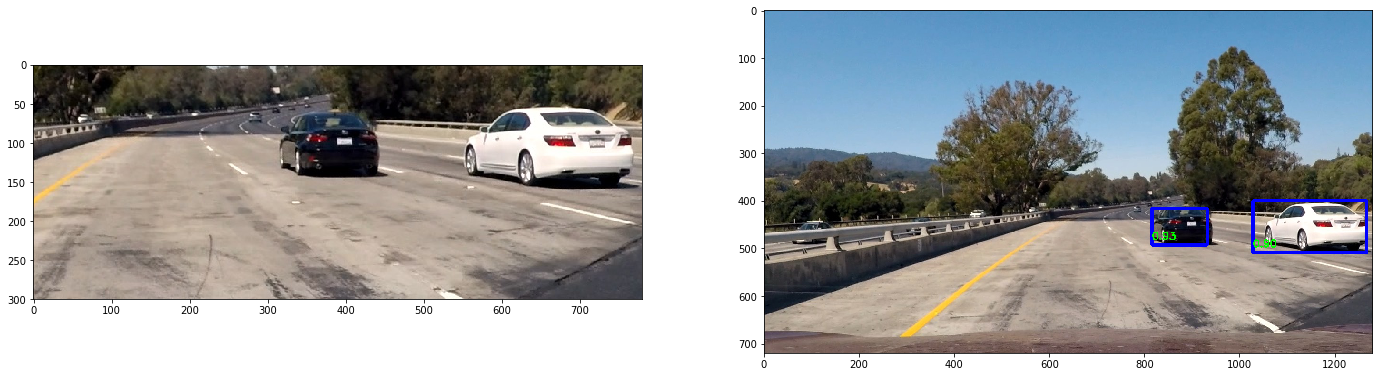

In [10]:

image = cv2.imread('./test_images/test1.jpg')
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(24,9))
image_crop = image[350:650,500:,:]
ax1.imshow(image_crop[:,:,::-1])
# print(image_crop.shape)
input_image = cv2.resize(image_crop, (416, 416))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = tiny_modelv2.predict(input_image)
image_out = interpret_netout(image, netout[0])
# plt.imshow(image_out[:,:,::-1]);
ax2.imshow(image_out[:,:,::-1])
plt.show()

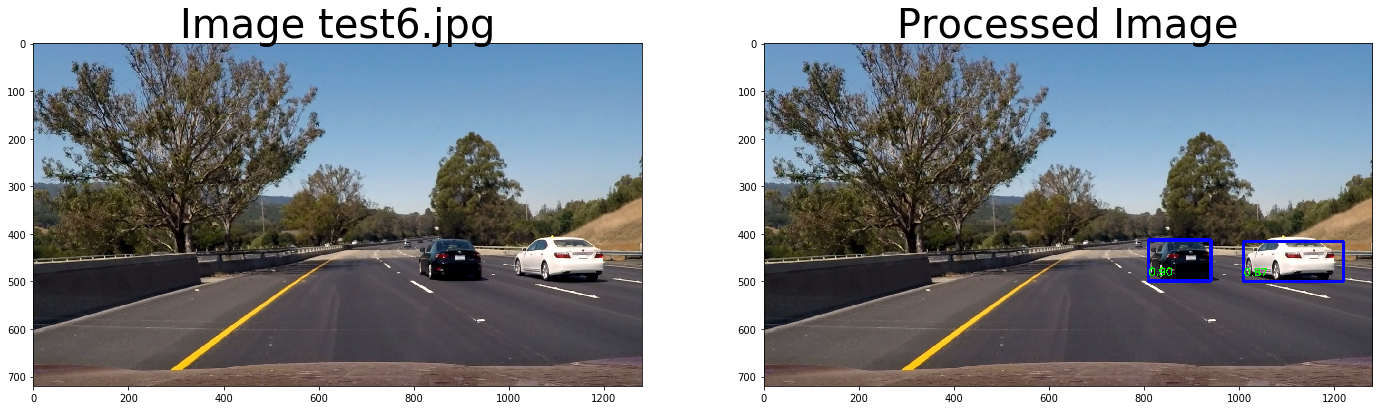

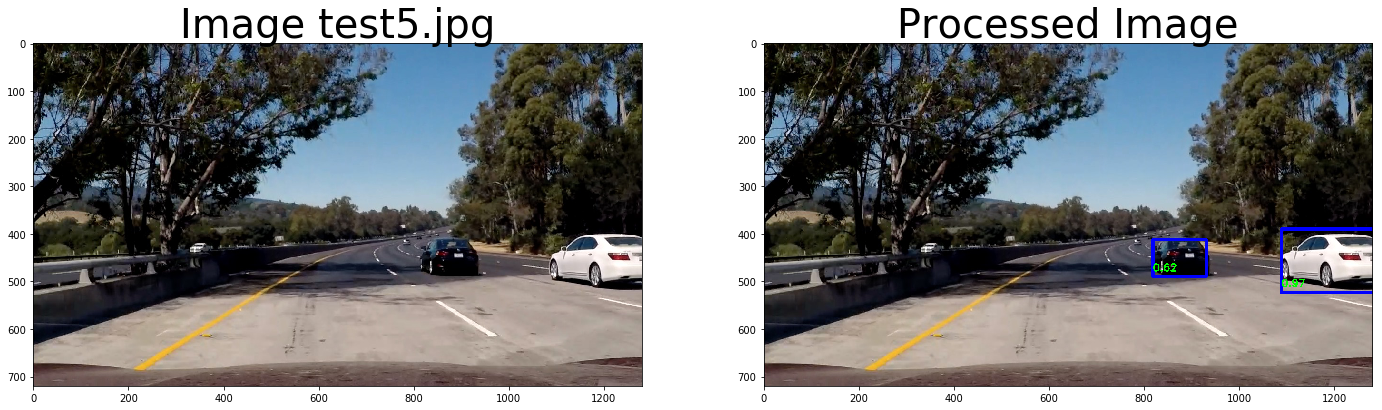

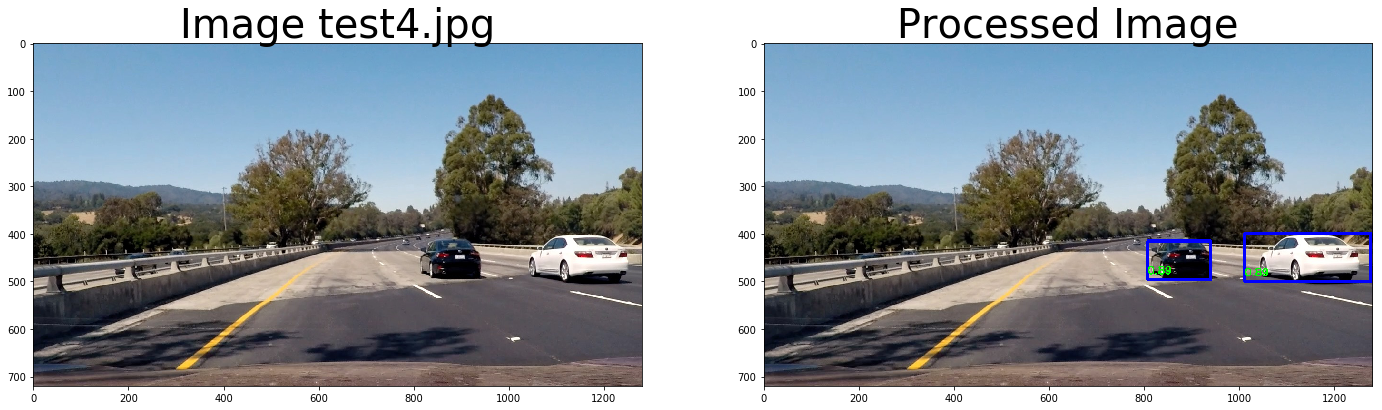

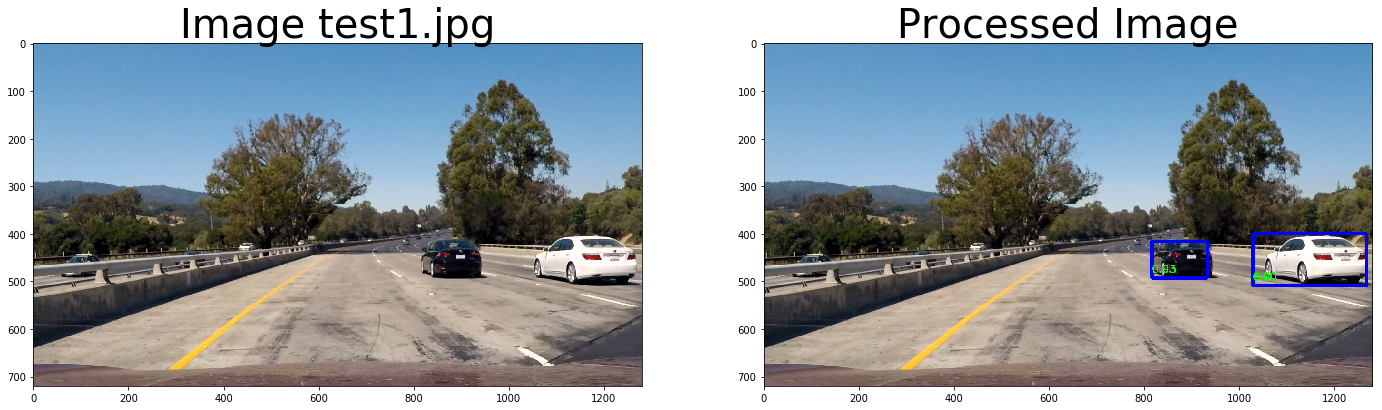

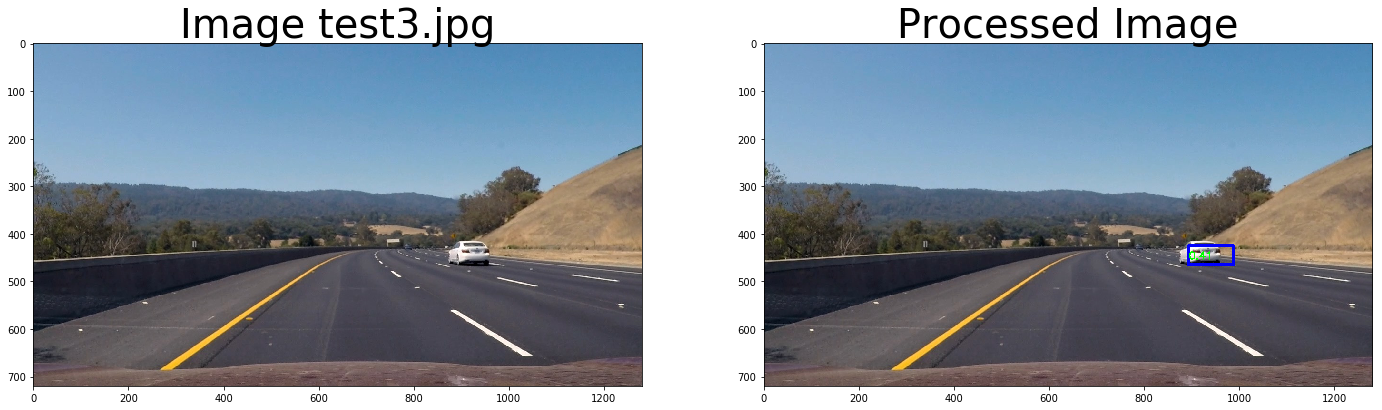

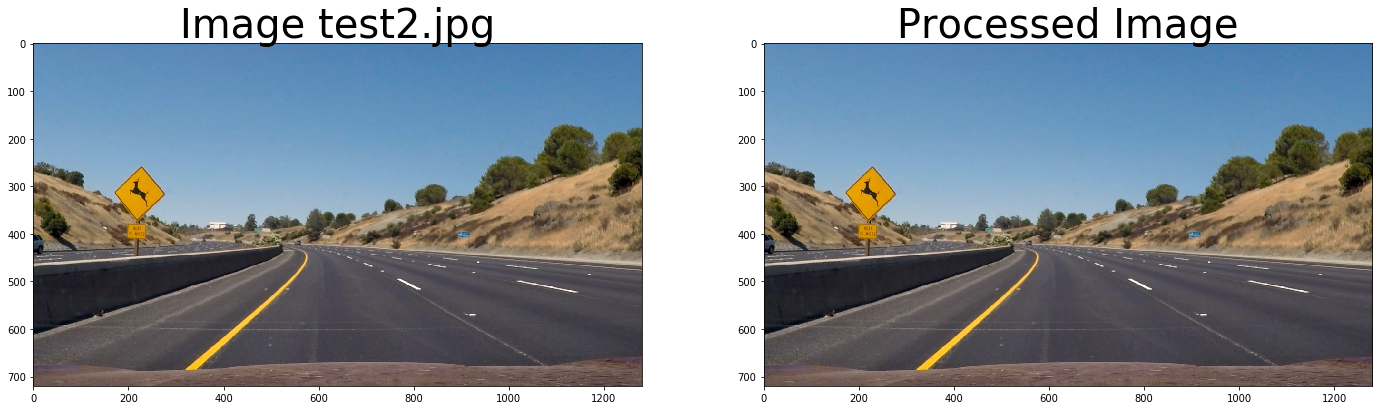

In [25]:
file = glob.glob('./test_images/*.jpg')
for fname in file:
    image = cv2.imread(fname)
    i_image = image.copy()
    image_crop = image[350:650,500:,:]
    input_image = cv2.resize(image_crop, (416, 416))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)
    out = tiny_modelv2.predict(input_image)
    out_image = interpret_netout(image, out[0])
    f,(ax1, ax2) = plt.subplots(1,2,figsize=(24,9))
    ax1.imshow(i_image[:,:,::-1])
    ax1.set_title('Image {}'.format(fname.split('/')[-1]), fontsize=40)
    ax2.imshow(out_image[:,:,::-1])
    ax2.set_title('Processed Image', fontsize=40)
    plt.show()
    f.savefig('./output_images/'+fname.split('/')[-1]+'_detected.png', bbox_inches='tight')

# f.savefig('./output_images/detected.png', bbox_inches='tight')

### Pipeline for video frames

In [12]:
def pipeline(image):
    image_crop = image[350:650,500:,:]
    input_image = cv2.resize(image_crop, (416, 416))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)
    out = tiny_modelv2.predict(input_image)
    out_image = interpret_netout(image, out[0])
    return out_image

### Output the video

In [13]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_video_output = './full_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")#.subclip(40,50)

In [14]:
lane_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ./full_output.mp4
[MoviePy] Writing video ./full_output.mp4


100%|█████████▉| 1260/1261 [08:48<00:00,  2.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./full_output.mp4 

CPU times: user 17min 53s, sys: 2min 16s, total: 20min 10s
Wall time: 8min 49s
